# Product Image and Video Generation with Amazon Nova and Amazon Bedrock: Background Replacement, Motion, and Overlay Techniques

## Introduction

In the rapidly evolving world of digital product marketing, creating high-quality, dynamic video content can be challenging. This notebook demonstrates a comprehensive workflow for generating professional product videos using Amazon Bedrock's image and video generation capabilities. 

Our use case focuses on addressing common challenges in product videography using Generative AI, specifically:

1. **Background Transformation**: Replacing product backgrounds seamlessly using outpainting techniques to create visually compelling environments.
2. **Controlled Video Motion**: Generating videos with background movement while keeping the product stationary, ideal for product showcases.
3. **Logo and Text Preservation**: Implementing a frame-by-frame overlay technique to prevent logo and text distortion during video generation.

By combining Amazon Bedrock's Nova Canvas and Reel models, we'll walk through a step-by-step process that enables creators and marketers to:

- Dynamically place products in new, imaginative settings
- Create short, engaging product videos
- Maintain brand identity by preserving original product details

This workflow is particularly useful for:
- E-commerce product marketing
- Brand promotional content
- Social media advertising
- Product demonstration videos

The notebook provides practical, reusable code that can be adapted to various product types and marketing scenarios.


## Detailed Step-by-Step Workflow

### Step 1: Background Replacement with Mask Prompt
- **Objective**: Prepare and transform the original product image
- **Key Actions**:
  - Resize and pad the input image to meet 1280x720 video specifications
  - Use Amazon Bedrock's Nova Canvas for outpainting
  - Apply a mask prompt to preserve the product
  - Generate a new, contextually rich background

### Step 2: Video Generation with Amazon NOVA Reel
- **Objective**: Create a dynamic video with controlled motion
- **Key Actions**:
  - Use the image generated in Step 1 as the initial frame
  - Generate a 6-second video with background movement
  - Craft a precise text prompt for controlled motion

### Step 3: Background Removal
- **Objective**: Isolate the product with transparency
- **Key Actions**:
  - Remove the background from the image generated in Step 1
  - Prepare for frame overlay

### Step 4: Product Overlay and Final Video Composition
- **Objective**: Preserve brand identity and product details
- **Key Actions**:
  - Split generated video into individual frames
  - Overlay original product image (image generated in Step 3) on each frame
  - Reconstruct video with preserved product details


# Step 1: Background replacement using mask prompt

One way to replace the background in an image is to use the "OUTPAINTING" task type with a `maskPrompt` describing the object(s) to keep and a text prompt describing the new background. A common use case for this feature is placing a real product in a generated environment.

The script below will use the image on the left as input. It will replace the background behind the coffee maker by using the `maskPrompt` prompt *"product"* and the `text` prompt *"Product in a serene outdoor garden setting, soft morning light filtered through leaves. The product is placed in the middle of a white stone or marble platform, surrounded by lavender plants in soft focus. Fresh dewdrops on foliage catching sunlight. Delicate morning mist in background. Depth of field emphasizing product in foreground. Natural color palette with soft purples, greens, and white tones. Professional product photography, 8K resolution. Golden hour lighting creating gentle rim light on bottle edge and generating a shadow of the product. Hyper-realistic botanical details with macro-style flower elements. Clean, fresh atmosphere matching product aesthetic."*. 

The result will look similar to the image on the right. Note the realistic shadows and reflections that ground the original product into the generated scene.

<div style="display: flex; justify-content: space-between; align-items: center;">
  <div>
    <img src="./example_images/baby_oil.png" style="max-height: 300px; max-width: 100%;">
    <p style="text-align: center;">Input image</p>
  </div>
  <div>
    <img src="example_images/background-replacement-baby_oil.png" style="max-height: 300px; max-width: 100%;">
    <p style="text-align: center;">Output image</p>
  </div>
</div>


Edit the `text` prompt to experiment with putting the product in different settings.

Let's install the necessary libraries

In [1]:
%pip install moviepy 
%pip install --upgrade boto3
%pip install --upgrade ipython opencv-python-headless

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import libraries

In [2]:
from random import randint
from amazon_image_gen import BedrockImageGenerator
import file_utils
import logging
import base64
from datetime import datetime
import numpy as np
from PIL import Image
import io

The following utility function transforms input images to a consistent 1280x720 pixel format while preserving the original aspect ratio. It resizes the image, maintaining its proportions by adding white padding either vertically or horizontally. 

The function is able to pad in three different `pad_modes: left, center and right`. `left` will position the product at the left and pad at the right, `center` will leave the product at the center of the image and pad both to the left and right and finally, `right` will position the producct at the right and add pad to the left.

An additional argument `resize_percent`can be provided in the funtion to reduce the size of the product to fit better on the new scene

The result is a standardized image prepared for video generation, ensuring no distortion occurs during the transformation process.

In [3]:
def resize_and_pad_image(image_path, target_width=1280, target_height=720, pad_mode='center', resize_percent=50):
    # Read image
    img = Image.open(image_path)
    
    # Convert to RGB if needed
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Calculate aspect ratios
    target_aspect = target_width / target_height
    img_aspect = img.width / img.height
    
    if img_aspect > target_aspect:
        # Image is wider than target
        new_width = int(target_width * (resize_percent / 100))
        new_height = int((new_width / img_aspect))
        if pad_mode == 'center':
            pad_top = (target_height - new_height) // 2
            pad_bottom = target_height - new_height - pad_top
        elif pad_mode == 'left':
            pad_top = 0
            pad_bottom = target_height - new_height
        else:  # right
            pad_top = target_height - new_height
            pad_bottom = 0
        pad_left = (target_width - new_width) // 2
        pad_right = target_width - new_width - pad_left
    else:
        # Image is taller than target
        new_height = int(target_height * (resize_percent / 100))
        new_width = int((new_height * img_aspect))
        if pad_mode == 'center':
            pad_left = (target_width - new_width) // 2
            pad_right = target_width - new_width - pad_left
        elif pad_mode == 'left':
            pad_left = 0
            pad_right = target_width - new_width
        else:  # right
            pad_left = target_width - new_width
            pad_right = 0
        pad_top = (target_height - new_height) // 2
        pad_bottom = target_height - new_height - pad_top
    
    # Resize image
    img_resized = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # Create new white image with target size
    final_img = Image.new('RGB', (target_width, target_height), 'white')
    
    # Paste resized image onto white background
    final_img.paste(img_resized, (pad_left, pad_top))
    
    # Convert to base64
    buffered = io.BytesIO()
    final_img.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


The next code generates a new background for the provided product image using Amazon Nova and Amazon Bedrock's image generation capabilities. It configures outpainting parameters using `"outPaintingMode": "PRECISE"` to keep the bottle in focus.

In [4]:
prompt = """Product in a serene outdoor garden setting, soft morning light filtered through leaves. 
        The product is placed in the middle of a white stone or marble platform, surrounded by lavender plants in soft focus. 
        Fresh dewdrops on foliage catching sunlight. Delicate morning mist in background. 
        Depth of field emphasizing product in foreground. Natural color palette with soft purples, greens, and white tones. 
        Professional product photography, 8K resolution. Golden hour lighting creating gentle rim light on bottle edge and generating a shadow of the product. 
        Hyper-realistic botanical details with macro-style flower elements. Clean, fresh atmosphere matching product aesthetic."""

[INFO] Generating 1 image(s) with amazon.nova-canvas-v1:0 in region us-east-1
[INFO] Using seed: 449598210
[INFO] Request ID: 75dce402-2aad-41f4-80a8-edabe538f607


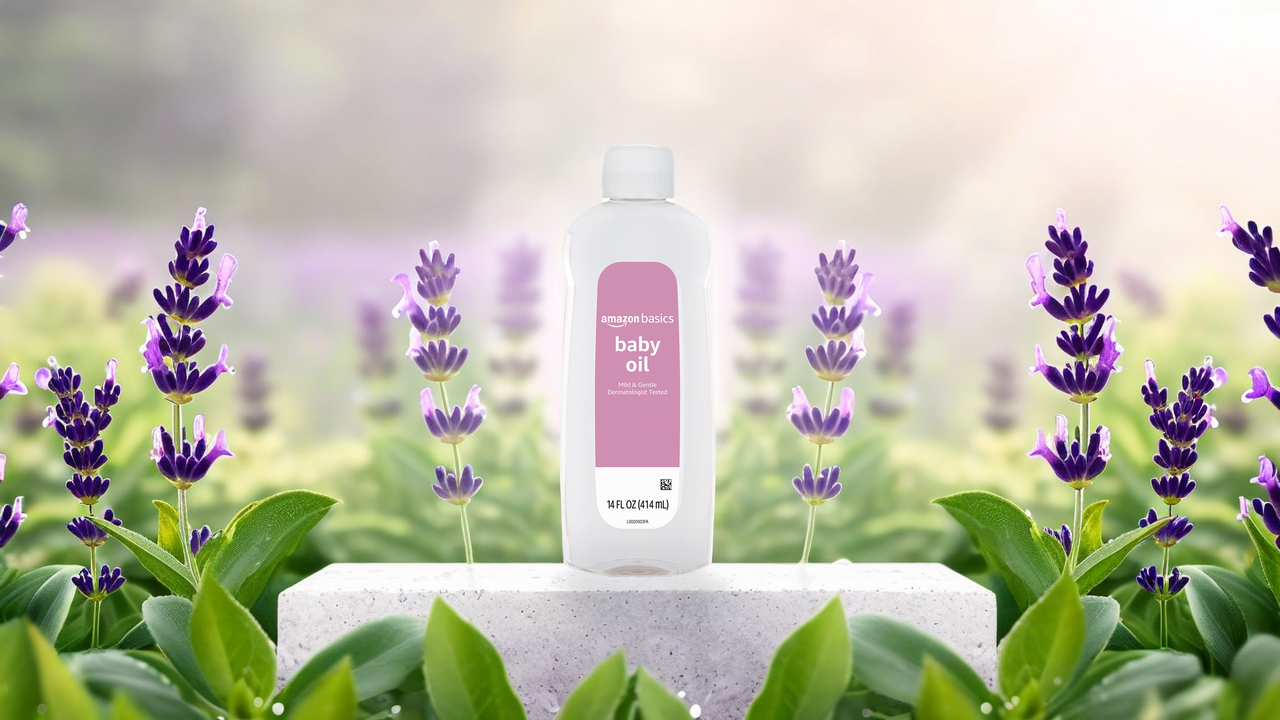

In [12]:
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')

# Set the image to be edited.
source_image = "example_images/baby_oil.png"

# Load and pad the image
source_image_base64 = resize_and_pad_image(source_image, 1280, 720, "center", 70)

# Configure the inference parameters.
inference_params = {
    "taskType": "OUTPAINTING",
    "outPaintingParams": {
        "image": source_image_base64,
        "text": prompt,  # Description of the background to generate
        "maskPrompt": "product",  # The element(s) to keep
        "outPaintingMode": "PRECISE",  # "DEFAULT" softens the mask. "PRECISE" keeps it sharp.
    },
    "imageGenerationConfig": {
        "numberOfImages": 1,  # Number of variations to generate. 1 to 5.
        "quality": "standard",  # Allowed values are "standard" and "premium"
        "cfgScale": 5.0,  # How closely the prompt will be followed
        "seed": randint(0, 858993459),  # Use a random seed
    },
}

# Define an output directory with a unique name.
generation_id = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_directory = f"output/bk-replacement-{generation_id}"

# Create the generator.
generator = BedrockImageGenerator(
    output_directory=output_directory
)

# Generate the image(s).
response_background_replacement = generator.generate_images(inference_params)

if "images" in response_background_replacement:
    # Save and display each image
    images = file_utils.save_base64_images(response_background_replacement["images"], output_directory, "image")
    for image in images:
        display(image)

Now that we have the image, let's generate a video using the previous generated image as an initial starting image together with a text prompt.

## Step 2: Video Generation with Amazon Nova Reel

Generating a video takes some time - approximately 3.5 minutes to produce a 6 second video. To accomodate this execution time, the Bedrock Runtime introduces a new asynchronous invocation API. Calling `start_async_invoke()` creates a new invocation job. When the job completes, Bedrock automatically saves the generated video to an S3 bucket you specify.

### Image-to-Video

You can also generate videos by providing an initial starting image and a text prompt. For best results, the text prompt should describe the image and also provide details about the desired action and camera movement you'd like the video to have.

**NOTE:** For this use case we need a static camera shot and the product to remain still. 

Modify the `s3_destination_bucket` and `video_prompt` variables at the start of the code below and then run the cell to start generating your video.


In [6]:
import boto3
import logging

logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')
logger = logging.getLogger(__name__)

VIDEO_MODEL_ID = "amazon.nova-reel-v1:0"

# Set default region and credentials.
boto3.setup_default_session(
    region_name="us-east-1"
)

The next code configures an asynchronous video generation process using Amazon Bedrock. It uses the background-replaced image as a reference, defines a video prompt for a static product with moving background, and initiates a 6-second video generation job with fixed dimensions and a random seed. 

In [8]:
# Specify your video generation prompt. Phrase your prompt as a summary rather than a command. Maximum 512 characters.
video_prompt = """

Static camera shot. The product remains completely still, 
peaceful garden scene with gentle natural movement. Slow motion. 
Early morning atmosphere with filtered sunlight in the background.

"""

In [27]:
import json
import random
import base64
import amazon_video_util

"""
IMPORTANT: Modify the S3 destination (s3_destination_bucket) and video prompt (video_prompt) below.
"""

# Specify an S3 bucket for the video output.
s3_destination_bucket = "bedrock-video-generation-us-east-1-hqhqna"  # Change this to a unique bucket name.

# Define the image to use as the input image.
if "images" in response_background_replacement:
    first_image_base64 = response_background_replacement["images"][0]  # Gets the reference image. Must be 1280 x 720

"""
STOP: You should not have to modify anything below this line.
"""

# Set up the S3 client.
s3_client = boto3.client("s3")

# Create the S3 bucket.
s3_client.create_bucket(Bucket=s3_destination_bucket)

# Create the Bedrock Runtime client.
bedrock_runtime = boto3.client("bedrock-runtime")

model_input = {
    "taskType": "TEXT_VIDEO",
    "textToVideoParams": {
        "text": video_prompt,
        "images": [
            {
                "format": "png",  # May be "png" or "jpeg"
                "source": {
                    "bytes": first_image_base64
                }
            }
        ]
        },
    "videoGenerationConfig": {
        "durationSeconds": 6,  # 6 is the only supported value currently.
        "fps": 24,  # 24 is the only supported value currently.
        "dimension": "1280x720",  # "1280x720" is the only supported value currently.
        "seed": random.randint(
            0, 2147483648
        ),  # A random seed guarantees we'll get a different result each time this code runs.
    },
}

try:
    # Start the asynchronous video generation job.
    invocation = bedrock_runtime.start_async_invoke(
        modelId=VIDEO_MODEL_ID,
        modelInput=model_input,
        outputDataConfig={"s3OutputDataConfig": {"s3Uri": f"s3://{s3_destination_bucket}"}},
    )

    # This will be used by other cells in this notebook.
    invocation_arn = invocation["invocationArn"]

    # Pretty print the response JSON.
    logger.info("\nResponse:")
    logger.info(json.dumps(invocation, indent=2, default=str))

    # Save the invocation details for later reference. Helpful for debugging and reporting feedback.
    amazon_video_util.save_invocation_info(invocation, model_input)

except Exception as e:
    logger.error(e)

[INFO] 
Response:
[INFO] {
  "ResponseMetadata": {
    "RequestId": "e3845094-6e99-4a42-b36d-aee40ee38740",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Wed, 18 Dec 2024 02:04:32 GMT",
      "content-type": "application/json",
      "content-length": "84",
      "connection": "keep-alive",
      "x-amzn-requestid": "e3845094-6e99-4a42-b36d-aee40ee38740"
    },
    "RetryAttempts": 0
  },
  "invocationArn": "arn:aws:bedrock:us-east-1:776299153297:async-invoke/g0ymnhwfxc0v"
}
[INFO] Getting async invoke details for ARN: arn:aws:bedrock:us-east-1:776299153297:async-invoke/g0ymnhwfxc0v
[INFO] Generated folder name: 2024-12-18_02-04-31_g0ymnhwfxc0v
[INFO] Saving invocation info to folder: /home/sagemaker-user/use-cases/product-ad/output/2024-12-18_02-04-31_g0ymnhwfxc0v
[INFO] Saved start_async_invoke_response.json
[INFO] Saved model_input.json


### Checking the status of generation jobs

We've provided a set of utility functions in the `amazon_video_util.py` script. One of these functions will automatically download a job if it is completed or monitor it while it is in-progress. The `invocation_arn` is defined in the code cell above and passed in below. This function will return the local file path for the generated video for successfully completed jobs.

In [28]:
output_directory_video = amazon_video_util.monitor_and_download_video(invocation_arn, "output")

[INFO] Monitoring and downloading video for ARN: arn:aws:bedrock:us-east-1:776299153297:async-invoke/g0ymnhwfxc0v
[INFO] Monitoring and downloading in-progress video for ARN: arn:aws:bedrock:us-east-1:776299153297:async-invoke/g0ymnhwfxc0v
[INFO] Job g0ymnhwfxc0v is still in progress, elapsed time: 0 minutes 5 seconds
[INFO] Job g0ymnhwfxc0v is still in progress, elapsed time: 0 minutes 15 seconds
[INFO] Job g0ymnhwfxc0v is still in progress, elapsed time: 0 minutes 25 seconds
[INFO] Job g0ymnhwfxc0v is still in progress, elapsed time: 0 minutes 36 seconds
[INFO] Job g0ymnhwfxc0v is still in progress, elapsed time: 0 minutes 46 seconds
[INFO] Job g0ymnhwfxc0v is still in progress, elapsed time: 0 minutes 56 seconds
[INFO] Job g0ymnhwfxc0v is still in progress, elapsed time: 1 minutes 6 seconds
[INFO] Job g0ymnhwfxc0v is still in progress, elapsed time: 1 minutes 16 seconds
[INFO] Job g0ymnhwfxc0v is still in progress, elapsed time: 1 minutes 26 seconds
[INFO] Job g0ymnhwfxc0v is still 

### Viewing output video
You can then view your output video by running the below cell:

In [29]:
from IPython.display import Video
Video(output_directory_video, embed=True, height=300)

To correct the distorted brand logos and texts, we will use a simple technique which consist in overlaying the product on top of each frame of the video. 

We will first remove the background from the image provided as an initial starting image for the video generation.

# Step 3: Background removal

The background removal feature of the Amazon Nova Canvas model automatically isolates the subject of an image from its background, returning a PNG with 8 bit transparency.

<div style="display: flex; justify-content: space-between; align-items: center;">
  <div>
    <img src="example_images/background-replacement-baby_oil.png" style="max-height: 300px; max-width: 100%;">
    <p style="text-align: center;">Input image</p>
  </div>
  <div>
    <img src="example_images/background-removal-baby_oil.png" style="max-height: 300px; max-width: 100%;">
    <p style="text-align: center;">Output image</p>
  </div>
</div>

[INFO] Generating 1 image(s) with amazon.nova-canvas-v1:0 in region us-east-1
[INFO] Request ID: 59a8e487-8abf-4e96-a432-09f98a3494a4


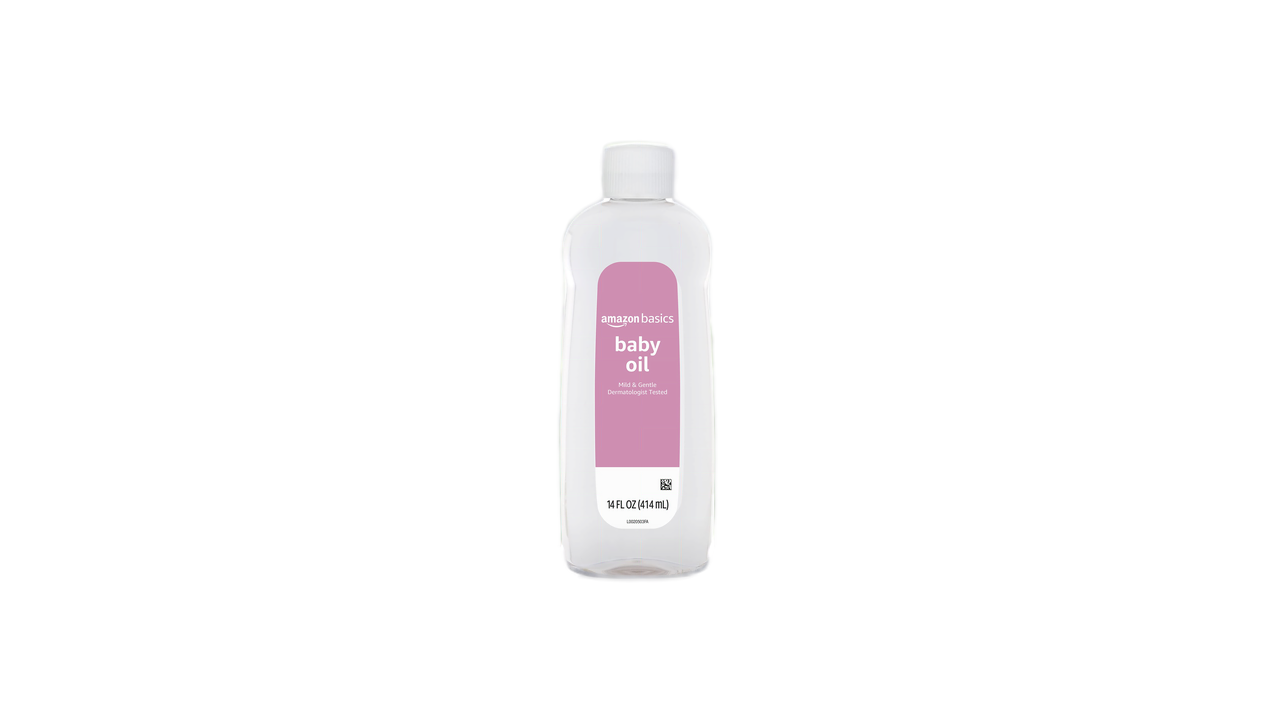

In [30]:
from amazon_image_gen import BedrockImageGenerator
import file_utils
import logging
import base64
from datetime import datetime

logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')

if "images" in response_background_replacement:
    first_image_base64 = response_background_replacement["images"][0]  # Get the first image

# Configure the inference parameters.
inference_params = {
    "taskType": "BACKGROUND_REMOVAL",
    "backgroundRemovalParams": {
        "image": first_image_base64,
    },
}

# Define an output directory with a unique name.
generation_id = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_directory_bk_removal = f"output/bk-removal-{generation_id}"

# Create the generator.
generator = BedrockImageGenerator(
    output_directory=output_directory_bk_removal
)

# Generate the image(s).
response_background_removal = generator.generate_images(inference_params)

if "images" in response_background_removal:
    # Save and display each image
    images = file_utils.save_base64_images(response_background_removal["images"], output_directory_bk_removal, "image")
    for image in images:
        display(image)

# Step 4: Product Overlay and Final Video Composition

This code implements a video processing workflow that handles product overlay on video frames. The script contains three main functions: `split_video_to_frames` extracts individual frames from a video file and saves them as images, `overlay_product` blends a product image with transparency onto a background frame while preserving alpha channels, and `create_video_with_overlay` combines everything by taking a folder of frames, overlaying a product image on each frame, and compiling them back into a video. 

The implementation uses OpenCV (cv2) for image and video processing, handling both BGR and BGRA color spaces to maintain transparency during the overlay process. [OpenCV (Open Source Computer Vision Library)](https://pypi.org/project/opencv-python/) is a powerful open-source library for computer vision and machine learning applications. The library contains over 2,500 optimized algorithms for tasks like image processing, object detection, facial recognition, and video analysis.

In [31]:
import cv2
import numpy as np
import os
from pathlib import Path

def split_video_to_frames(video_path, output_folder):
    # Create output folder if it doesn't exist
    Path(output_folder).mkdir(parents=True, exist_ok=True)

    # Read the video
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        # Save frame
        output_path = os.path.join(output_folder, f'frame_{frame_count:04d}.jpg')
        cv2.imwrite(output_path, frame)
        frame_count += 1
        
    cap.release()
    return frame_count

def overlay_product_simple(background, product_img):
    # Convert background to RGBA if needed
    if background.shape[2] == 3:
        background = cv2.cvtColor(background, cv2.COLOR_BGR2BGRA)
    
    # Extract the alpha channel
    alpha = product_img[:, :, 3] / 255.0
    
    # Blend the images using alpha channel
    for c in range(3):  # BGR channels
        background[:, :, c] = background[:, :, c] * (1 - alpha) + product_img[:, :, c] * alpha
    
    return background

def create_video_with_overlay(frames_folder, product_path, output_path, fps=24):
    # Read the product image (with alpha channel)
    product = cv2.imread(product_path, cv2.IMREAD_UNCHANGED)
    if product is None:
        raise ValueError("Could not load product image")
    
    # Get the first frame to determine video size
    first_frame = cv2.imread(os.path.join(frames_folder, sorted(os.listdir(frames_folder))[0]))
    height, width = first_frame.shape[:2]
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Process each frame
    for frame_file in sorted(os.listdir(frames_folder)):
        if frame_file.endswith(('.jpg', '.png')):
            # Read frame
            frame_path = os.path.join(frames_folder, frame_file)
            frame = cv2.imread(frame_path)
            
            # Overlay product
            frame_with_overlay = overlay_product_simple(frame, product)
            
            # Convert back to BGR for video writing
            if frame_with_overlay.shape[2] == 4:
                frame_with_overlay = cv2.cvtColor(frame_with_overlay, cv2.COLOR_BGRA2BGR)
            
            # Write frame
            out.write(frame_with_overlay)
    
    out.release()

Next, we will execute the defined functions step by step.

In [32]:
# Input paths
video_path = output_directory_video
product_path = output_directory_bk_removal + '/image_1.png'
frames_folder = 'videos/temp_frames'
output_path = 'videos/output_video_overlay.mp4'
        
# Convert base64 image to png
response_background_removal["images"][0]

# 1. Split video into frames
print("Splitting video into frames...")
frame_count = split_video_to_frames(video_path, frames_folder)

# 2 & 3. Overlay product and create new video
print("Creating video with overlay...")
create_video_with_overlay(frames_folder, product_path, output_path)

# Clean up temporary frames
print("Cleaning up...")
for frame_file in os.listdir(frames_folder):
    os.remove(os.path.join(frames_folder, frame_file))
os.rmdir(frames_folder)

print("Process completed!")

Splitting video into frames...
Creating video with overlay...
Cleaning up...
Process completed!


At last, we use the MoviePy library to convert the generated video back to H.264 format. [MoviePy](https://pypi.org/project/moviepy/) is a Python library for video editing: cuts, concatenations, title insertions, video compositing (a.k.a. non-linear editing), video processing, and creation of custom effects.

In [ ]:
from moviepy.video.io.VideoFileClip import VideoFileClip

def convert_to_h264(input_file, output_file):
    clip = VideoFileClip(input_file)
    clip.write_videofile(output_file, 
                        codec='libx264',
                        fps=24,
                        preset='medium',
                        bitrate='4000k')
    clip.close()

output_path_h264 = 'videos/output_video_overlay_h264.mp4'
convert_to_h264(output_path, output_path_h264)


MoviePy - Done !
MoviePy - video ready videos/output_video_overlay_h264.mp4


#### Great! Let's now visualize our final result!

In [ ]:
from IPython.display import Video
Video(output_path_h264, embed=True, height=300)
